# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening an **restaurant** in **Toronto**, Canada.

There are lots of restaurants in Toronto we will try to detect **locations where people used Restaurant mostly**. We are also particularly interested in **areas less common as a Restaurant**. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* Find the area where Restaurant are preferred choice than any other destinations
* Will look to Open Restaurant in best place
* Distance from City center


We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* Extract the Toronto data from Wikipedia page
* number of restaurants and their type and location in every neighborhood will be obtained using **Foursquare API**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from geopy.geocoders import Nominatim

def get_coordinates(addresses, verbose=False):
    """
    We will use this method for getting the Latitute and Longitude
    """
    geolocator = Nominatim(user_agent="ny_explorer")
    cordinates = {}
    for address in addresses:
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        cordinates[address]=[latitude,latitude]
        print('The geograpical coordinate of {} are {}, {}.'.format(address,latitude, longitude))
    return cordinates

Foursqure Credentials

In [3]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20180323'   #'20180604'

We will define a method which will fetch nearby places in the specified radius range

In [4]:
LIMIT=500
def getRestaurantData(latitude, longitude, radius=10000):
    search_query = 'Restaurant'
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query)


    venues_list=[]
    results=np.NAN
    # make the GET request
    try:
        results = requests.get(url).json()['response']['venues']
    except KeyError:
        return 
    # return only relevant information for each nearby venue

    for v in results:
        try:
            venues_list.append([(
                v['name'],
                v['location']['address'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['location']['distance'],
                v['location']['postalCode'],
                v['location']['city'],

                v['categories'][0]['name'], 
                v['categories'][0]['shortName'])])
        except KeyError:
            pass
        except IndexError:
            pass
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name','Address','Latitude',
                  'Longitude', 
                  'Distance', 
                  'PostalCode', 
                  'City', 
                  'Category','Category Short']
    
    return(nearby_venues)

We need to collect data from wikipedia page so, lets define the method for that

In [5]:
from bs4 import BeautifulSoup
import requests

#defining the function to make the request
def get_data_from_url(url):
    response = requests.get(url)
    data = response.text
    soup = BeautifulSoup(data,'html5lib')
    #print(soup)
    df = pd.DataFrame()
    for row in soup.find_all('tr'):
        arr = []
        for col in row.find_all('td'):
            arr.append(col.getText())  # col.getText()--> returning string
        df = df.append(pd.DataFrame(arr).T)
    return df

In [6]:
URL_Toronto = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df_toronto_wiki = get_data_from_url(URL_Toronto)
df_toronto_wiki.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M1A\n,Not assigned\n,Not assigned\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,M2A\n,Not assigned\n,Not assigned\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,M3A\n,North York\n,Parkwoods\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,M4A\n,North York\n,Victoria Village\n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,M5A\n,Downtown Toronto\n,"Regent Park, Harbourfront\n",NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Looks fine, We have scrapped the data from wiki page
Now we need to cleanm it so that only required information is available

In [7]:
df_toronto_wiki.columns = [str(n) for n in range(len(df_toronto_wiki.columns))] #for getting required columns only
df_toronto_wiki = df_toronto_wiki[['0','1','2']].replace(to_replace=r'\n',value='',regex=True)
df_toronto_wiki.reset_index(drop=True, inplace=True)
df_toronto_wiki.columns = ['Postal Code','Borough','Neighbourhood']
pd.set_option('display.max_rows', None)  # for validating data if possible
df_toronto_wiki.tail(5)

,Postal Code,Borough,Neighbourhood
179,M9Z,Not assigned,Not assigned
180,,,NaN
181,NLNSPENBQCONMBSKABBCNU/NTYTABCEGHJKLMNPRSTVXY,NL,NS
182,NL,NS,PE
183,A,B,C


There are four rows which are found inappropriate, Lets remove all those rows 

In [8]:
df_toronto_wiki = df_toronto_wiki.iloc[range(df_toronto_wiki.shape[0]-4)]  #Removing last 4 outlayers
df_toronto_wiki = df_toronto_wiki[df_toronto_wiki['Borough']!='Not assigned']  #Removed not assigned values
print(df_toronto_wiki[df_toronto_wiki['Neighbourhood']=='Not assigned'].shape)  # checking weather 'Not assigned' exist in Neighbourhood
df_toronto_wiki.reset_index(drop=True, inplace=True)

(0, 3)


In [9]:
df_toronto_wiki.head(5)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


Looks Great!! we now have the wiki data containing **Postal Code, Borough, Neighbourhood**. Now lets do some action to add Latitude and Longitude. For this we have Geospatial file which we will use to add those column

In [10]:
latlon  =  pd.read_csv('Geospatial_Coordinates.csv',delimiter=',')
df_toronto_wiki  = pd.merge(df_toronto_wiki, latlon, left_on='Postal Code', right_on='Postal Code') #Merging for Latitute and Longi
df_toronto_wiki.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Wonderful! Now we have a cleaned dataframe consisting of **Latitiude and Longitude**.

In [11]:
df_toronto_wiki.shape

(103, 5)

Get the cordinates of the required cities, in our case the city is **Toronto**. Lets get that address

In [12]:
addresses = ['Toronto, ON, Canada']
cord = get_coordinates(addresses=addresses)
cord

The geograpical coordinate of Toronto, ON, Canada are 43.6534817, -79.3839347.


{'Toronto, ON, Canada': [43.6534817, 43.6534817]}

Now lets use the *Foursquare API* to fetch the restaurant in the radius of 10KM for every Borough

In [13]:
toronto_restrt_df = pd.concat([getRestaurantData(latitude=lat,longitude=lon) for lat,lon in zip(df_toronto_wiki['Latitude'],df_toronto_wiki['Longitude']) ])
toronto_restrt_df = toronto_restrt_df[toronto_restrt_df['City']=='Toronto']
toronto_restrt_df.head(3)

,Name,Address,Latitude,Longitude,Distance,PostalCode,City,Category,Category Short
0,Katsura Japanese Restaurant 桂,900 York Mills Rd.,43.756259,-79.349571,1635,M3B 3H2,Toronto,Japanese Restaurant,Japanese
2,Friendship Restaurant,2912 Sheppard Ave. E,43.775670,-79.322363,2562,M1T 3J4,Toronto,Caribbean Restaurant,Caribbean
3,Golden Seven Chinese Cuisine Restaurant,3309 Sheppard Ave. E,43.776555,-79.306638,3185,M1T 3K2,Toronto,Chinese Restaurant,Chinese


Lets Clean the data for further processing

In [14]:
toronto_restrt_df.drop('Category', axis=1, inplace= True)
toronto_restrt_df.rename(columns={'Category Short':'Category'}, inplace=True)
toronto_restrt_df.drop('City', axis=1, inplace= True)
toronto_restrt_df.head()

,Name,Address,Latitude,Longitude,Distance,PostalCode,Category
0,Katsura Japanese Restaurant 桂,900 York Mills Rd.,43.756259,-79.349571,1635,M3B 3H2,Japanese
2,Friendship Restaurant,2912 Sheppard Ave. E,43.775670,-79.322363,2562,M1T 3J4,Caribbean
3,Golden Seven Chinese Cuisine Restaurant,3309 Sheppard Ave. E,43.776555,-79.306638,3185,M1T 3K2,Chinese
4,Darband Restaurant,879 York Mills Rd,43.755194,-79.348498,1530,M3B 1Y5,Middle Eastern
5,Scarlet Ibis Family Restaurant,30 Dean Park Rd,43.722610,-79.303666,4001,M1B 3H1,Caribbean


In [15]:
toronto_restrt_df = toronto_restrt_df[['Category','Distance','PostalCode','Latitude','Longitude']]
toronto_restrt_df.head()

,Category,Distance,PostalCode,Latitude,Longitude
0,Japanese,1635,M3B 3H2,43.756259,-79.349571
2,Caribbean,2562,M1T 3J4,43.775670,-79.322363
3,Chinese,3185,M1T 3K2,43.776555,-79.306638
4,Middle Eastern,1530,M3B 1Y5,43.755194,-79.348498
5,Caribbean,4001,M1B 3H1,43.722610,-79.303666


Wonderful, we now hace all the restaurant location with category. Lets compare with wiki_df with restaurant df. Both have some common feature. Lets combine them

In [16]:
toronto_restrt_df.shape

(1510, 5)

In [17]:
df_toronto_wiki.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [18]:
df_toronto_wiki.shape

(103, 5)

In [19]:
temp = toronto_restrt_df['PostalCode'].str.split(' ',expand=True)
temp.columns = ['0','1','3']
toronto_restrt_df.drop('PostalCode', inplace=True,axis=1)
toronto_restrt_df['PostalCode']=temp['0']
toronto_restrt_df.head()

In [23]:
toronto_df = pd.merge(toronto_restrt_df, df_toronto_wiki,  how='inner', left_on='PostalCode', right_on ='Postal Code')

In [24]:
toronto_df.drop('Postal Code',axis=1,inplace=True)

In [25]:
toronto_df.head()

,Category,Distance,Latitude_x,Longitude_x,PostalCode,Borough,Neighbourhood,Latitude_y,Longitude_y
0,Japanese,1635,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
1,Middle Eastern,1530,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188
2,Japanese,4348,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
3,Japanese,1171,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
4,Middle Eastern,1075,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188


Excellent, ***DATA WRANGLING ANS SCRAPPING COMPLETED***

## EDA

Lets make a copy of the dataframe so that our actual dataframe will unaffected from the ongoing operation.

In [26]:
df = toronto_df.copy()  

Lets Check how many specific restaurnat are there so that we could some details

In [27]:
df_bar = df['Category'].value_counts().head(10).to_frame()

df_bar['Type'] = df_bar.index


df_bar.columns = ['Counts','Category']

df_bar.reset_index(drop=True,inplace=True)
df_bar

,Counts,Category
0,270,Restaurant
1,231,Chinese
2,128,Breakfast
3,121,American
4,107,Caribbean
5,81,Ethiopian
6,73,Korean
7,69,Thai
8,66,Japanese
9,57,Indian


Lets plot the Barplot so that we could understand the current situtation

Text(0, 0.5, 'Number of Restaurant')

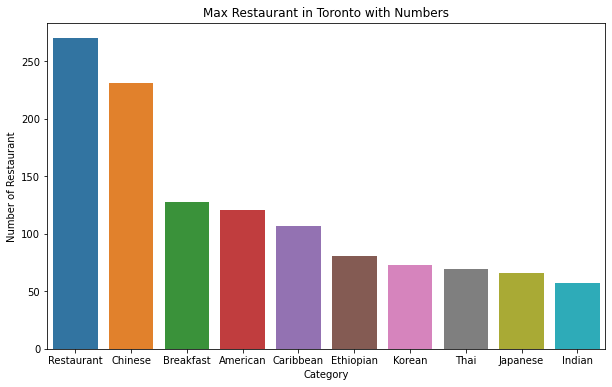

In [28]:
# Set the width and height of the figure
plt.figure(figsize=(10,6))

# Add title
plt.title("Max Restaurant in Toronto with Numbers")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df_bar['Category'], y=df_bar['Counts'])

# Add label for vertical axis
plt.ylabel("Number of Restaurant")

Lets plot a graph between the no of restaurant with mean distance from the city center

In [29]:
df_borough = df.groupby(['Borough']).count()
# mean_distance = 
mean = (df.groupby(['Borough']).mean()['Distance'])
df_borough['Borough'] =  df_borough.index
df_borough.rename(columns={'Category':'Count'},inplace=True)
df_borough = df_borough[['Count','Borough']]
df_borough['AVG distance f citycenter'] =mean
df_borough = df_borough.reset_index(drop=True)

Lets Normalize the data so that it could cross the graph boundry and it get provide the actual trend or relation between those attributes

In [30]:
x= df_borough['Count'] = df_borough['Count']/df_borough['Count'].max()
y = df_borough['AVG distance f citycenter'] = df_borough['AVG distance f citycenter']/df_borough['AVG distance f citycenter'].max()


In [31]:
heat = pd.DataFrame([x,y]).T 

In [32]:
df_borough

,Count,Borough,AVG distance f citycenter
0,0.095411,Central Toronto,0.393226
1,1.000000,Downtown Toronto,0.697312
2,0.071256,East Toronto,0.414342
3,0.048309,East York,0.452795
4,0.035024,Etobicoke,1.000000
5,0.117150,North York,0.631939
6,0.287440,Scarborough,0.837367
7,0.146135,West Toronto,0.973832
8,0.015700,York,0.166365


Now lets plot the graph, before that we will sort the data so that it could be easy to understand

In [33]:
df_borough = df_borough.sort_values(by=['Count','AVG distance f citycenter'])

Text(0, 0.5, 'Normalized value:')

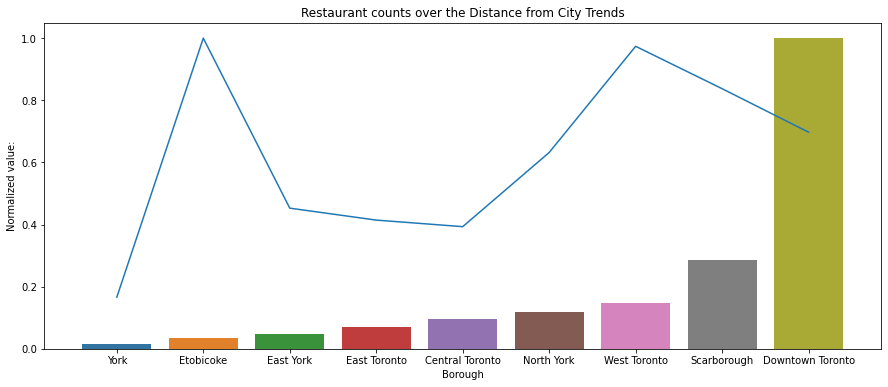

In [34]:
# Set the width and height of the figure
plt.figure(figsize=(15,6))

# Add title
plt.title("Restaurant counts over the Distance from City Trends")

# Bar chart showing average arrival delay for Spirit Airlines flights by month
sns.barplot(x=df_borough['Borough'], y=df_borough['Count'])
sns.lineplot(x=df_borough['Borough'], y=df_borough['AVG distance f citycenter'])

# Add label for vertical axis
plt.ylabel("Normalized value:")

From the Above diagram we can observe that ***York,  Etibicoke, East York, East Toronto, Central Toronto *** has less distance with city center and also has less no of restaurant

Lets Expolore the locality for understanding the people preference in these Borough

In [35]:
df_localP = df.groupby('Borough').mean().copy()
df_localP.head()

,Distance,Latitude_x,Longitude_x,Latitude_y,Longitude_y
Borough,,,,,
Central Toronto,2486.367089,43.696981,-79.395842,43.701342,-79.392371
Downtown Toronto,4409.101449,43.656674,-79.391255,43.656906,-79.391799
East Toronto,2619.881356,43.666183,-79.344011,43.663848,-79.340302
East York,2863.025000,43.687442,-79.325678,43.688769,-79.335430
Etobicoke,6323.000000,43.690054,-79.568277,43.703598,-79.586497


In [36]:
df_localP['Borough'] = df_localP.index
df_localP['Lat'] = df_localP['Latitude_x']
df_localP['Lon'] = df_localP['Longitude_x']
df_localP.reset_index(drop=True,inplace=True)
df_localP = df_localP[['Borough','Lat','Lon']]
df_localP

,Borough,Lat,Lon
0,Central Toronto,43.696981,-79.395842
1,Downtown Toronto,43.656674,-79.391255
2,East Toronto,43.666183,-79.344011
3,East York,43.687442,-79.325678
4,Etobicoke,43.690054,-79.568277
5,North York,43.751419,-79.415785
6,Scarborough,43.777329,-79.286711
7,West Toronto,43.643801,-79.431482
8,York,43.688536,-79.457503


In [37]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [38]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            pass
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [39]:
LIMIT=100
def getNearbyVenuesResult(names, latitude, longitude, radius=500):
     # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)

    # make the GET request
    results = requests.get(url).json()
    return results

Recursevly we are fetching nearby venue in the borough

In [40]:
toronto_venues  = getNearbyVenues(latitudes=df_localP['Lat'],longitudes=df_localP['Lon'],names=df_toronto_wiki['Borough'])
toronto_venues.head()

,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,43.696981,-79.395842,Balsamico,43.701505,-79.397162,Italian Restaurant
1,North York,43.696981,-79.395842,Oriole Park,43.697114,-79.399293,Park
2,North York,43.696981,-79.395842,La Salumeria,43.701255,-79.397117,Deli / Bodega
3,North York,43.696981,-79.395842,Little Sister,43.701552,-79.397163,Indonesian Restaurant
4,North York,43.696981,-79.395842,Rachel's Coffee House,43.701021,-79.397027,Café


We do have the all the nearby venues for every Borough

In [41]:
toronto_venues.shape

(565, 7)

In [42]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 162 uniques categories.


In [43]:
def hot_encode(dataframe):
# one hot encoding
    df = pd.get_dummies(dataframe[['Venue Category']], prefix="", prefix_sep="")

    # add neighborhood column back to dataframe
    df['Borough'] = dataframe['Borough'] 

    # move neighborhood column to the first column
    fixed_columns = [df.columns[-1]] + list(df.columns[:-1])
    df = df[fixed_columns]
    return df

After Hot encoding lets group those values by Borough and take the mean for that

In [44]:
toronto_grouped = hot_encode(toronto_venues).groupby('Borough').mean().reset_index()
toronto_grouped.head()

,Borough,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Downtown Toronto,0.00000,0.028571,0.009524,0.00000,0.00000,0.009524,0.009524,0.00000,0.038095,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.047619,0.00000,0.019048,0.00,0.000000
1,East York,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.04,0.000000
2,Etobicoke,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000
3,North York,0.00289,0.008671,0.000000,0.00578,0.00289,0.011561,0.005780,0.00289,0.011561,...,0.000000,0.00289,0.020231,0.000000,0.00289,0.008671,0.00578,0.000000,0.00,0.008671
4,Scarborough,0.00000,0.000000,0.000000,0.00000,0.00000,0.015625,0.000000,0.00000,0.000000,...,0.015625,0.00000,0.000000,0.015625,0.00000,0.015625,0.00000,0.015625,0.00,0.000000


Lets define some methods so that it could provide the most common values and do sorting for us

In [45]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [46]:
def sort_based_on_preference(grouped_df):
    num_top_venues = 10  #Assume we want 10 most prefered

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = []
    for ind in np.arange(num_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))
    print(len(columns))
    # create a new dataframe
    df = pd.DataFrame(columns=columns)
    df['Borough'] = grouped_df['Borough']
    return df

In [47]:
toronto_borough_venues_sorted = sort_based_on_preference(toronto_grouped)
num_top_venues=10
for ind in np.arange(toronto_grouped.shape[0]):
    toronto_borough_venues_sorted.iloc[ind, 0:-1] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

toronto_borough_venues_sorted.head()

10


,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough
0,Coffee Shop,Café,Vietnamese Restaurant,Bakery,Restaurant,Hotel,Pizza Place,Sandwich Place,Park,Bar,Downtown Toronto
1,Pharmacy,Park,Grocery Store,Convenience Store,Beer Store,Cosmetics Shop,Pizza Place,Dessert Shop,Discount Store,Falafel Restaurant,East York
2,Coffee Shop,Restaurant,Gas Station,Park,Burger Joint,Bubble Tea Shop,French Restaurant,Sandwich Place,Thai Restaurant,Dog Run,Etobicoke
3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant,North York
4,Burrito Place,Sandwich Place,Fast Food Restaurant,Coffee Shop,Sporting Goods Shop,Bookstore,Supermarket,Bank,Gas Station,Pharmacy,Scarborough


Looks good, Now we need to fetch those places whose first 7th common place is restaurant

In [48]:
mask = toronto_borough_venues_sorted[toronto_borough_venues_sorted.columns.to_list()[:-1]].astype(str).agg('-'.join,axis=1)
mask = mask.str.contains('Restaurant','Dinner')
toronto_restaurant_preferred = toronto_borough_venues_sorted[mask]

In [49]:
toronto_restaurant_preferred.groupby('Borough').count()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
Downtown Toronto,1,1,1,1,1,1,1,1,1,1
East York,1,1,1,1,1,1,1,1,1,1
Etobicoke,1,1,1,1,1,1,1,1,1,1
North York,1,1,1,1,1,1,1,1,1,1
Scarborough,1,1,1,1,1,1,1,1,1,1


In [50]:
mask = toronto_borough_venues_sorted[toronto_borough_venues_sorted.columns.to_list()[5:]].astype(str).agg('-'.join,axis=1)
mask = mask.str.contains('Restaurant','Dinner')
toronto_restaurant_preferred = toronto_borough_venues_sorted[mask]

In [51]:
toronto_restaurant_preferred.groupby('Borough').count()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,,,,,,,,,,
East York,1,1,1,1,1,1,1,1,1,1
Etobicoke,1,1,1,1,1,1,1,1,1,1
North York,1,1,1,1,1,1,1,1,1,1


In [52]:
toronto_restaurant_preferred.groupby('Borough').count().index.to_list()

['East York', 'Etobicoke', 'North York']

So these above Borough are best 5 choice as a destination  for the people

Lets visalilze at Map

In [53]:
cord

{'Toronto, ON, Canada': [43.6534817, 43.6534817]}

For visualizing the points on the map, we need folium so lets import that and create a map object

In [54]:
import folium
map_toronto = folium.Map(location=[cord['Toronto, ON, Canada'][0], cord['Toronto, ON, Canada'][1]], zoom_start=11)  #Map Created

In [55]:
toronto_df.head()  # Our output of the data scrapping phase

,Category,Distance,Latitude_x,Longitude_x,PostalCode,Borough,Neighbourhood,Latitude_y,Longitude_y
0,Japanese,1635,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
1,Middle Eastern,1530,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188
2,Japanese,4348,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
3,Japanese,1171,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
4,Middle Eastern,1075,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188


Defining a method which will put marker on the map

In [56]:
def put_marker(df,map_obj):
    for lat, lng, borough, neighborhood,category in zip(df['Latitude_x'], df['Longitude_x'], df['Borough'], df['Neighbourhood'],df['Category']):
        label = '{} ,{}, {}'.format(category, neighborhood, borough)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_obj) 

In [57]:
put_marker(toronto_df,map_toronto)

In [58]:
toronto_grouped.head()

,Borough,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Downtown Toronto,0.00000,0.028571,0.009524,0.00000,0.00000,0.009524,0.009524,0.00000,0.038095,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.047619,0.00000,0.019048,0.00,0.000000
1,East York,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.04,0.000000
2,Etobicoke,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000
3,North York,0.00289,0.008671,0.000000,0.00578,0.00289,0.011561,0.005780,0.00289,0.011561,...,0.000000,0.00289,0.020231,0.000000,0.00289,0.008671,0.00578,0.000000,0.00,0.008671
4,Scarborough,0.00000,0.000000,0.000000,0.00000,0.00000,0.015625,0.000000,0.00000,0.000000,...,0.015625,0.00000,0.000000,0.015625,0.00000,0.015625,0.00000,0.015625,0.00,0.000000


In [59]:
toronto_borough_venues_sorted.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough
0,Coffee Shop,Café,Vietnamese Restaurant,Bakery,Restaurant,Hotel,Pizza Place,Sandwich Place,Park,Bar,Downtown Toronto
1,Pharmacy,Park,Grocery Store,Convenience Store,Beer Store,Cosmetics Shop,Pizza Place,Dessert Shop,Discount Store,Falafel Restaurant,East York
2,Coffee Shop,Restaurant,Gas Station,Park,Burger Joint,Bubble Tea Shop,French Restaurant,Sandwich Place,Thai Restaurant,Dog Run,Etobicoke
3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant,North York
4,Burrito Place,Sandwich Place,Fast Food Restaurant,Coffee Shop,Sporting Goods Shop,Bookstore,Supermarket,Bank,Gas Station,Pharmacy,Scarborough


In [60]:
from sklearn.cluster import KMeans

In [80]:
toronto_grouped.set_index('Borough', inplace=True)

In [81]:
toronto_grouped

,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
Borough,,,,,,,,,,,,,,,,,,,,,
Downtown Toronto,0.00000,0.028571,0.009524,0.00000,0.00000,0.009524,0.009524,0.00000,0.038095,0.009524,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.047619,0.00000,0.019048,0.00,0.000000
East York,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.040000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.04,0.000000
Etobicoke,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000
North York,0.00289,0.008671,0.000000,0.00578,0.00289,0.011561,0.005780,0.00289,0.011561,0.014451,...,0.000000,0.00289,0.020231,0.000000,0.00289,0.008671,0.00578,0.000000,0.00,0.008671
Scarborough,0.00000,0.000000,0.000000,0.00000,0.00000,0.015625,0.000000,0.00000,0.000000,0.031250,...,0.015625,0.00000,0.000000,0.015625,0.00000,0.015625,0.00000,0.015625,0.00,0.000000


Now we do have the data which we can use in clustering for visualizing the cluster

In [82]:
# set number of clusters
kclusters = 5

#toronto_grouped_clustering = toronto_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 2, 4, 0])

In [83]:
toronto_grouped_clustering.shape

(5, 162)

In [84]:
toronto_grouped_clustering.head()

,Accessories Store,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,0.00000,0.028571,0.009524,0.00000,0.00000,0.009524,0.009524,0.00000,0.038095,0.009524,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.047619,0.00000,0.019048,0.00,0.000000
1,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.040000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.04,0.000000
2,0.00000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.040000,...,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.00,0.000000
3,0.00289,0.008671,0.000000,0.00578,0.00289,0.011561,0.005780,0.00289,0.011561,0.014451,...,0.000000,0.00289,0.020231,0.000000,0.00289,0.008671,0.00578,0.000000,0.00,0.008671
4,0.00000,0.000000,0.000000,0.00000,0.00000,0.015625,0.000000,0.00000,0.000000,0.031250,...,0.015625,0.00000,0.000000,0.015625,0.00000,0.015625,0.00000,0.015625,0.00,0.000000


In [64]:
#map_toronto

## Analysis <a name="analysis"></a>

In [86]:
toronto_df.head()

,Category,Distance,Latitude_x,Longitude_x,PostalCode,Borough,Neighbourhood,Latitude_y,Longitude_y
0,Japanese,1635,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
1,Middle Eastern,1530,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188
2,Japanese,4348,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
3,Japanese,1171,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188
4,Middle Eastern,1075,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188


In [65]:
# add clustering labels
toronto_borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(toronto_borough_venues_sorted.set_index('Borough'), on='Borough')

toronto_merged.head() # check the last columns!

,Category,Distance,Latitude_x,Longitude_x,PostalCode,Borough,Neighbourhood,Latitude_y,Longitude_y,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Japanese,1635,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
1,Middle Eastern,1530,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
2,Japanese,4348,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
3,Japanese,1171,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
4,Middle Eastern,1075,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188,3.0,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant


In [78]:
toronto_merged.shape

(1232, 20)

In [66]:
toronto_merged['Cluster Labels'].value_counts()

3.0    925
0.0    238
1.0     40
2.0     29
Name: Cluster Labels, dtype: int64

In [67]:
toronto_merged.dropna(inplace=True)

In [71]:
toronto_merged


,Category,Distance,Latitude_x,Longitude_x,PostalCode,Borough,Neighbourhood,Latitude_y,Longitude_y,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Japanese,1635,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
1,Middle Eastern,1530,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
2,Japanese,4348,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
3,Japanese,1171,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
4,Middle Eastern,1075,43.755194,-79.348498,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
5,Diner,982,43.753310,-79.358837,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
6,Japanese,3450,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
7,Japanese,5371,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
8,Japanese,7455,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant
9,Japanese,2489,43.756259,-79.349571,M3B,North York,Don Mills,43.745906,-79.352188,3,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Restaurant,Park,Bar,Gastropub,Thai Restaurant,Sushi Restaurant


In [68]:

toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)


In [69]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[cord['Toronto, ON, Canada'][0], cord['Toronto, ON, Canada'][1]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude_x'], toronto_merged['Longitude_x'], toronto_merged['Borough'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the Map we can see that there is More interest of people in ***East York*** and it also less distance from city center
***Downtown Toronto*** is also a good option we invest far from the city center
***Scarborough*** is good if we move through the costal areas.

## Results and Discussion <a name="results"></a>



Our analysis shows that although there is a great number of restaurants in Downtown Toronto, there are pockets of low restaurant density fairly far to city center. Highest concentration of restaurants was detected at city center, so we focused our attention to areas which are far away from city center. Another borough was identified as potentially interesting (East York, Scarborough),  these are also good in context of people interest and less in counts in the area


## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify best areas with low number of restaurants and high people interest in Restaurant. By calculating restaurant density distribution from Foursquare data we have first identified general boroughs that justify further analysis , and then generated extensive collection of locations which satisfy some basic requirements regarding existing nearby restaurants. Clustering of those locations was then performed in order to create major zones of interest (containing greatest number of potential locations) and addresses of those zone centers were created to be used as starting points for final exploration by stakeholders.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.